In [13]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
with open("2b_avg_pd_equilibrium", 'rb') as pickle_file:
    avg_pd_2b = pickle.load(pickle_file)

with open("3b_avg_pd_equilibrium", 'rb') as pickle_file:
    avg_pd_3b = pickle.load(pickle_file)

with open("4b_avg_pd_equilibrium", 'rb') as pickle_file:
    avg_pd_4b = pickle.load(pickle_file)

# Combine the arrays along the second axis (axis=1)
combined_array = np.concatenate((avg_pd_2b, avg_pd_3b, avg_pd_4b), axis=1)

# Verify the shape of the combined array
print(combined_array.shape)  # Output will be (12, 180, 1)

# Reshape the array to (12, 60) before creating the DataFrame
reshaped_data = np.array(combined_array).reshape(12, 180)

# Create a DataFrame
avg_df = pd.DataFrame(reshaped_data) # Ground Truth

(12, 180, 1)


In [7]:
with open("2b_all_pd_equilibrium", 'rb') as pickle_file:
    equil_pd_2b = pickle.load(pickle_file)

with open("3b_all_pd_equilibrium", 'rb') as pickle_file:
    equil_pd_3b = pickle.load(pickle_file)

with open("4b_all_pd_equilibrium", 'rb') as pickle_file:
    equil_pd_4b = pickle.load(pickle_file)

# Combine the arrays along the second axis (axis=1)
all_array = np.concatenate((equil_pd_2b, equil_pd_3b, equil_pd_4b), axis=2)
print(np.shape(all_array))
all_array = all_array.reshape(-1,all_array.shape[2])
print(np.shape(all_array))

# Create labels array
# Define the maximum number of repetitions for each number
max_repetitions = 13
# Define the range of numbers from 0 to 11
numbers_range = np.arange(12)
# Create the array
labels = np.repeat(numbers_range, max_repetitions)
print(np.shape(labels))
all_equilibrium_df = pd.DataFrame(all_array)

(12, 13, 180)
(156, 180)
(156,)


Compute KL Divergence

0     0.014500
1     0.025653
2     0.000953
3     0.002412
4     0.002758
5     0.005197
6     0.008200
7     0.009836
8     0.005690
9     0.002687
10    0.004020
11    0.016872
12    0.009850
dtype: float64


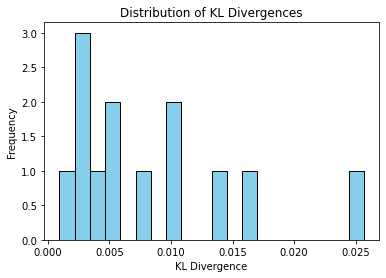

In [15]:
import pandas as pd
from scipy.stats import entropy

# https://datascience.stackexchange.com/questions/9262/calculating-kl-divergence-in-python
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

# Take the first 13 rows of df1
df1_first_13 = all_equilibrium_df.iloc[:13]

# Take the first row of df2
reference_row = avg_df.iloc[0]
avg_df
# Compute KL divergence for each row in df1_first_13 relative to reference_row
kl_divergences = []
for index, row in df1_first_13.iterrows():
    kl_divergence = entropy(row, reference_row)
    kl_divergences.append(kl_divergence)

# Convert the list of KL divergences to a pandas Series
kl_divergences_series = pd.Series(kl_divergences, index=df1_first_13.index)

print(kl_divergences_series)

import matplotlib.pyplot as plt

# Assuming kl_divergences_series contains the computed KL divergences

# Plot a histogram of KL divergences
plt.hist(kl_divergences_series, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of KL Divergences')
plt.xlabel('KL Divergence')
plt.ylabel('Frequency')
plt.show()
